# Some notes on the Hartigans' dip test

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from unidip.dip import dip_fn, diptst


## Hartigan's dip test

### Background

![](https://skeptric.com/images/multimodal_pdf_cdf.png)
_Figure from https://skeptric.com/dip-statistic/_

Hartigan's dip test measures the distance between a distribution and it's closest unimodal approximation.
Intuitively, if this distance is small, it is likely unimodal, but if it is large, it is probably not unimodal.
A distribution is unimodal with mode $m$ if its cumulative distribution function (cdf) is convex below $m$ and concave after $m$. 
Indeed the mode need not be unique: the distribution can have a `flat' top.
In that case, the cdf is linearly increasing on the modal interval. 
The idea is to find a function that consists of a convex part, a linear part and a concave part that is as close to the cdf as possible. 
This will describe a unimodal distribution, and the distance between the two is the *dip statistic* we need.

Formally, measure the distance between two distribution functions as their largest difference $\rho(F, G) = \sup_x |F(x) - G(x)|$. If $\mathcal{U}$ is the collection of all unimodal distributions, then the dip statistic is defined as 
\begin{align}
    D(F) = \inf_{G \in \mathcal{U}} \rho(F, G).
\end{align}
Hartigan & Hartigan prove that $D(F) = d$ only if there is a nondecreasing function $G$ and some modal interval $[x_L, x_R]$ such that:

1. $G$ is the *greatest convex minorant* of $F+d$ on $(-\infty, x_L)$. That means that $G(x) is the largest convex function that lies below $F(x) + d$ on that interval.
2. $G$ has a constant, maximum slope on the modal interval $(x_L, x_R)$.
3. $G$ is the *least concave majorant* of $F-d$ on $(x_R, \infty)$. That means that $G(x) is the smallest concave function above $F(x)-d$ on that interval.
4. The dip is:
\begin{align}
    d 
        &= \sup_{x \notin (x_L, x_R)} |F(x) - G(x)| \\
        &\ge \sup_{x \in (x_L, x_R)} |F(x) - G(x)|
\end{align}

### Illustration

In [2]:
def illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)

    L = len(left) - 1
    R = len(idxs) - len(right)
    xL = idxs[L]
    xR = idxs[R]

    plt.plot(idxs, cdf, 'k--', label='cdf', lw=.5)
    plt.plot(idxs[:R], cdf[:R]+dip, '0.5', lw=0.5, label='cdf $F \pm d$')
    plt.fill_between(idxs, cdf+dip, cdf-dip, color='0.5', alpha=.05,)
    plt.plot(idxs[L:], cdf[L:]-dip, '0.5', lw=0.5)

    plt.plot(idxs[:L+1], left + dip, '-', lw=1, 
        label='$G$, convex part')
    plt.plot([xL, xR], [left[-1] + dip, right[0] - dip], '-', lw=1, 
        label='$G$, modal interval')
    plt.plot(idxs[R:], right - dip, '-', lw=1, 
        label='$G$, concave part')

    plt.axvline(idxs[L], c='k', ls=':', lw=.5)
    plt.axvline(idxs[R], c='k', ls=':', lw=.5)

    plt.annotate('$x_L$', xy=(idxs[L], 1.1), ha='center', va='bottom', backgroundcolor='w')
    plt.annotate('$x_R$', xy=(idxs[R], 1.1), ha='center', va='bottom', backgroundcolor='w')

    plt.legend()

# plt.figure(figsize=cm2inch(10, 6))
# dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dataset)
# illustrate_dip_statistic(idxs, cdf, left, right, dip)

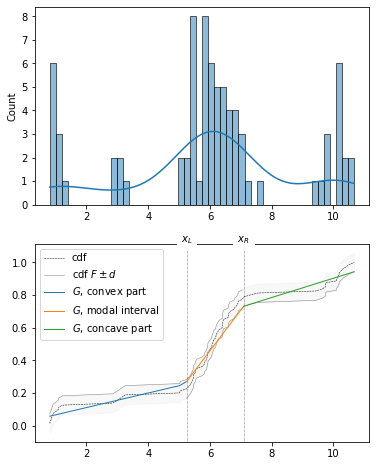

In [3]:
dataset = np.r_[
    np.random.normal(1, .15, size=10), 
    np.random.normal(3, .15, size=5), 
    np.random.normal(6, .6, size=50),
    np.random.normal(10, .4, size=15),
]

fig, axs = plt.subplots(2, figsize=(6, 8))
sns.histplot(dataset, ax=axs[0], bins=50, kde=True)
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dataset)
illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=axs[1])

In [4]:
dip, pval, (left_idx, right_idx) = diptst(dataset, is_hist=False, numt=1000)
dip, pval

(0.057159811738640876, 0.055944055944055944)

### Effect of bimodality

The dip of course correlates with the separation of bimodal data: the further the two modes are apart, the larger the dip.

In [5]:
mode_distances = np.linspace(0, .7, 50)
datasets = [
    np.r_[np.random.normal(0, .1, size=100), np.random.normal(d, .1, size=100)]
    for d in mode_distances
]

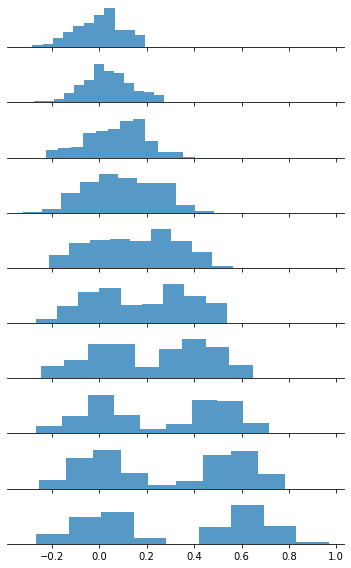

In [6]:
fig, axs = plt.subplots(len(datasets[::5]), sharex=True, figsize=(5, 8), tight_layout=True)
for ax, dist, dataset in zip(axs, mode_distances, datasets[::5]):
    sns.histplot(dataset, ax=ax, lw=0)
    sns.despine(left=True)
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.annotate(f'{dist:.2f}', xy=(-.4,10), fontsize=6)

In [7]:
dips = []
pvals = []
for dataset in datasets:
    dip, pval, (left_idx, right_idx) = diptst(dataset, is_hist=False, numt=500)
    dips.append(dip)
    pvals.append(pval)

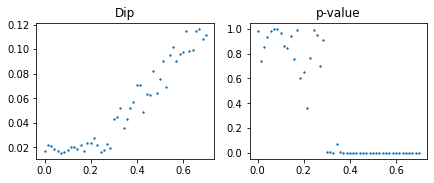

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))
axs[0].scatter(mode_distances, dips, s=2)
axs[0].set_title('Dip')

axs[1].set_title('p-value')
plt.scatter(mode_distances, pvals, s=2)

## Computing the dip

### Greatest convex minorant

The *greatest convex minorant* of a function $F$ is the greatest function that is
below $F$, but still convex. To find it, start at the first point $(x_0, y_0)$ of
the function and compute the slope $s_i$ towards every other point $(x_i, y_i)$ by
\begin{align}
    s_i = \frac{x_i - x_0}{y_i - y_0}.
\end{align}
If $s_j$ is the smallest slope, all other points $(x_i, y_i)$ must lie 
above the line $L$ through $(x_0, y_0)$ and the _touchpoint_ $(x_j, y_j)$. 
In fact, this line $L$ is the greatest convex minorant of $F$ on the interval 
$[x_0, x_j]$. After all, if a function $G$ is greater than $L$ and still below $F$, 
then it must go through the touchpoint $(x_j, y_j)$. But being greater than $L$ 
means that $G(x) > L(x)$ for some $x \in (x_0, x_j)$, which means exactly that 
$G$ is not convex.
We can now repeat this argument starting from $x_j$, find the next point with
smallest slope, start from there, and so on, untill we reach the end. The 
piecewise linear function connecting all touchpoints is the greatest convex 
minorant. 
To find the _least concave majorant_, we simply flip the function around and 
look for the greatest convex minorant of $y_N - F$ if $y_N$ is the largest value
of $F$.

In [9]:
def greatest_convex_minorant(xs, ys):
    touchpoint_idxs = [0]
    gcm = [ys[0]]
    while touchpoint_idxs[-1] < len(xs) - 1:
        start = touchpoint_idxs[-1]

        # Slope from starting point to all other points
        distances = xs[start + 1:] - xs[start]
        slopes = (ys[start + 1:] - ys[start]) / distances
        
        # Identify the next touchpoint (xn, yn) and the slope to it. The greatest convex
        # minorant must be linear between (x0, y0) and (xn, yn).
        # Indexing wrt xs/ys, so add +1 as we skip the first point
        index = slopes.argmin() + 1 
        slope = slopes[index - 1]

        # Add a point on the gcm for every x in xs before the touch point
        gcm.extend(ys[start] + slope * distances[:index])
        touchpoint_idxs.append(start + index)
    
    return np.array(gcm), np.array(touchpoint_idxs)

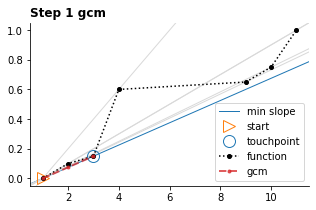

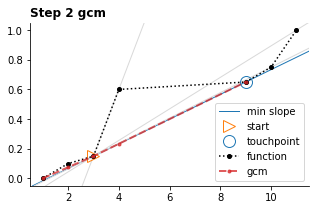

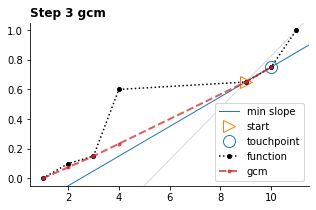

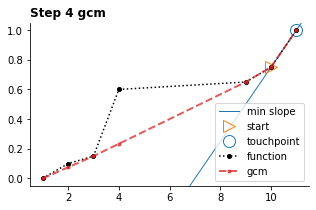

In [10]:
def show_steps_gcm(xs, ys):
    """Illustrate the algorithm for finding the greatest convex minorant gcm"""
    touchpoint_idxs = [0]
    gcm_ys = [ys[0]]
    while touchpoint_idxs[-1] < len(xs) - 1:
        start = touchpoint_idxs[-1]

        # Slope from starting point to all other points
        distances = xs[start + 1:] - xs[start]
        slopes = (ys[start + 1:] - ys[start]) / distances
        
        # Identify the next touchpoint (xn, yn) and the slope to it. The greatest convex
        # minorant must be linear between (x0, y0) and (xn, yn).
        # Indexing wrt xs/ys, so add +1 as we skip the first point
        index = slopes.argmin() + 1 
        slope = slopes[index - 1]

        # Add a point on the gcm for every x in xs before the touch point
        gcm_ys.extend(ys[start] + slope * distances[:index])
        touchpoint_idxs.append(start + index)

        # Plot
        plt.figure(figsize=(5, 3))
        for i in range(start+1, len(xs)):
            plt.axline((xs[start], ys[start]), (xs[i], ys[i]), 
                c='C0' if i == start + index else '.85', 
                label='min slope' if i == start + index else None,
                ls='-', lw=1)
        plt.plot(xs[start], ys[start], '>C1', ms=12, 
            fillstyle='none', label='start')
        plt.plot(xs[start + index], ys[start + index], 'oC0', ms=12, 
            fillstyle='none', label='touchpoint')
        plt.plot(xs, ys, 'ko:', label='function', ms=4)
        plt.plot(xs[:len(gcm_ys)], gcm_ys, '.C3--', label='gcm', lw=2, alpha=.75)
        plt.legend()
        plt.title(f'Step {len(touchpoint_idxs)-1} gcm', x=0, ha='left', fontweight='bold')
        sns.despine()

xs = np.array([1,  2,  3,  4,  9,  10, 11])
ys = np.array([0, .1, .15, .6, .65, .75, 1])
show_steps_gcm(xs, ys)

### Least concave majorant

The **least concave majorant** is the smallest function above $F$ that is still
concave. To find this, we can flip the function around, and then look for the 
greatest convex minorant:

In [11]:
def least_concave_majorant(xs, ys):
    ys_inv = np.max(ys) - ys[::-1]
    xs_inv = np.max(xs) - xs[::-1]
    lcm_inv, touchpoints_inv = greatest_convex_minorant(xs_inv, ys_inv)
    lcm = np.max(ys) - lcm_inv[::-1]
    touchpoints = len(xs) - touchpoints_inv - 1
    return lcm, touchpoints

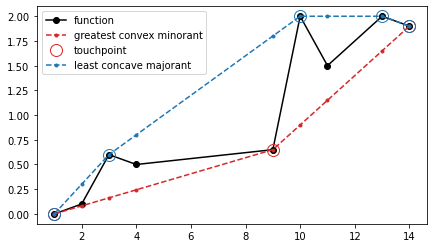

In [12]:
def show_gcm_and_lcm(xs, ys, ax=None):
    if ax is None: ax = plt.gca()
    gcm, gcm_touchpoints = greatest_convex_minorant(xs, ys)
    ax.plot(xs, ys, 'ko-', label='function')
    ax.plot(xs, gcm, 'C3.--', label='greatest convex minorant')
    ax.plot(xs[gcm_touchpoints], ys[gcm_touchpoints], 'oC3', ms=12, 
        fillstyle='none', label='touchpoint')

    lcm, lcm_touchpoints = least_concave_majorant(xs, ys)
    plt.plot(xs, lcm, 'C0--.', label='least concave majorant')
    plt.plot(xs[lcm_touchpoints], lcm[lcm_touchpoints], 'C0o', 
        fillstyle='none', ms=12)
    ax.legend()

xs = np.array([1,  2,  3,  4,  9,  10, 11, 13, 14])
ys = np.array([0, .1, .6, .5, .65, 2,  1.5,  2, 1.9])
plt.figure(figsize=(7, 4))
show_gcm_and_lcm(xs, ys)

Note that all this works for bounded functions, not only for nondecreasing ones
like the cumulative distribution functions we will be looking at now.

### The dip computation (incomplete/incorrect)

**Nota bene** To do: there is some error in this illustration...

In [13]:
xs = np.array([1,  2,  3,  4,  9,  10, 11])
ys = np.array([0, .1, .15, .6, .65, .75, 1])

In [14]:
def cumulative_distribution_function(data):
    """Compute the cumulative distribution function"""
    counts = Counter(data)
    xs = np.msort(list(counts.keys()))
    histogram = np.array([counts[x] for x in xs], dtype=float)
    histogram /= histogram.sum()
    cdf = np.cumsum(histogram)
    cdf /= cdf[-1]
    return xs, cdf, histogram

In [15]:
def abs_diff(F, G, where=None):
    assert len(F) == len(G)
    if where is None: where = None
    return np.abs(F[where] - G[where])

In [16]:
def show_dip_computation_step(xs, ys, left, right, gcm, lcm, gcm_touch, lcm_touch, dip_idx):
    # Plot the dips
    plt.figure(figsize=(6, 4))
    for idx in gcm_touch:
        plt.plot([xs[idx], xs[idx]], [gcm[idx], lcm[idx]], 'C3')
    for idx in lcm_touch:
        plt.plot([xs[idx], xs[idx]], [gcm[idx], lcm[idx]], 'C0')

    # Highlight largest dip
    plt.plot([xs[dip_idx], xs[dip_idx]], [gcm[dip_idx], lcm[dip_idx]], 
        'k', lw=10, alpha=.15, label='largest dip')

    # Show left and right
    plt.axvline(xs[left], c='0.5', ls=':')
    plt.axvline(xs[right], c='0.5', ls=':')

    # Function with GCM and LCM
    show_gcm_and_lcm(xs, ys)

(0.15546218487394958, 0, 2)

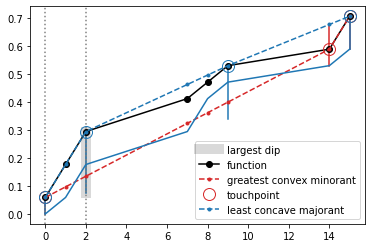

In [17]:
def dip_computation_step(xs, cdf, histogram, D: float = 0, plot=True):
    N = len(xs)
    assert len(cdf) == N and len(histogram) == N
    
    # Compute greatest convex minorant and least concave majorant
    gcm, gcm_touch = greatest_convex_minorant(xs, cdf - histogram)
    lcm, lcm_touch = least_concave_majorant(xs, cdf)
    gcm_dips = abs_diff(gcm, lcm, where=gcm_touch)
    lcm_dips = abs_diff(gcm, lcm, where=lcm_touch)

    # Determine the largest dip and the left and right index
    if gcm_dips.max() > lcm_dips.max():
        # Left = index of the GCM touchpoint with the largest dip 
        # Right = the next touchpoint of LCM
        dip = gcm_dips.max()
        dip_idx = gcm_touch[gcm_dips.argmax()]
        left = gcm_touch[gcm_dips.argmax()]
        right = lcm_touch[np.where(lcm_touch > left)[0][0]]

    else:
        # Right = index of the LCM touchpoint with the largest dip 
        # Left = the previous touchpoint of GCM
        dip = lcm_dips.max()
        dip_idx = lcm_touch[lcm_dips.argmax()]
        right = lcm_touch[lcm_dips.argmax()]
        left = gcm_touch[np.where(gcm_touch < right)[0][-1]]

    max_dip_left = abs_diff(gcm, cdf, where=np.arange(0, left+1)).max()
    max_dip_right = abs_diff(lcm, right - histogram, where=np.arange(right, N)).max()
    
    # Continue or finished?
    if dip <= D or right == 0 or left == N:
        return True, dip, left, right
    else:
        D = max(D, max_dip_left, max_dip_right)

    if plot:
        show_dip_computation_step(
            xs, cdf, left, right, gcm, lcm, gcm_touch, lcm_touch, dip_idx)
        plt.plot(xs, cdf-histogram)
        
    return False, D, left, right

def compute_dip(data):
    xs, cdf, histogram = cumulative_distribution_function(data)
    left = 0
    right = len(xs) - 1
    D = 0
    done = False
    while done == False:
        done, D, next_left, next_right = dip_computation_step(
            xs[left:right], 
            cdf[left:right], 
            histogram[left:right], 
            D
        )
        if not done:
            right = left + next_right
            left += next_left
        else:
            # ...
            gcm, _ = greatest_convex_minorant(xs, cdf - histogram)
            lcm, _ = least_concave_majorant(xs, cdf)
            max_dip_left = abs_diff(cdf, gcm, where=np.arange(0, left+1)).max()
            max_dip_right = abs_diff(cdf, lcm, where=np.arange(right, len(xs))).max()
            dip = max(max_dip_left, max_dip_right) / 2
            
            return dip, left, right


data = [0, 1, 1, 2, 8, 7, 9, 2, 7, 15, 16, 15, 14, 16, 16, 16, 16]
compute_dip(data)

## References

Adolfsson, A., Ackerman, M., & Brownstein, N. C. (2019). To cluster, or not to cluster: An analysis of clusterability methods. *Pattern Recognition, 88*, 13–26. https://doi.org/10/ggh2gq

Hartigan, J. A., & Hartigan, P. M. (1985). The Dip Test of Unimodality. *The Annals of Statistics, 13*(1), 70–84. https://doi.org/10/ctwtms

Kalogeratos, A., & Likas, A. (2012). Dip-means: An incremental clustering method for estimating the number of clusters. Advances in Neural Information Processing Systems 25, 2393–2401.

Maurus, S., & Plant, C. (2016). Skinny-dip: Clustering in a Sea of Noise. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 1055–1064. https://doi.org/10/gh274j


Informal introduction: https://skeptric.com/dip-statistic/

